In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
# Load the CSV file
df = pd.read_csv('/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv')

# Display the first few rows
print(df.head())

# Check the shape of the dataframe
print(f"Dataset shape: {df.shape}")


          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Dataset shape: (10015, 8)


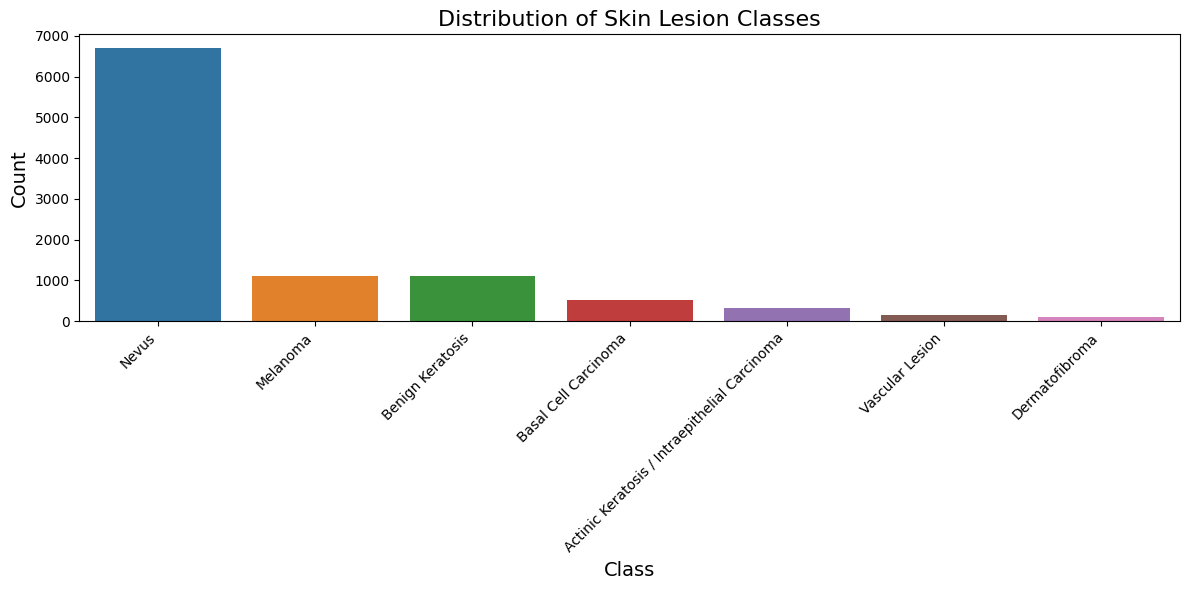

Class distribution percentages:
                                           Class   Count  Percentage
1                                          Nevus  6705.0       66.95
0                                       Melanoma  1113.0       11.11
4                               Benign Keratosis  1099.0       10.97
2                           Basal Cell Carcinoma   514.0        5.13
3  Actinic Keratosis / Intraepithelial Carcinoma   327.0        3.27
6                                Vascular Lesion   142.0        1.42
5                                 Dermatofibroma   115.0        1.15


In [3]:
# Define class names for readability
class_names = {
    'MEL': 'Melanoma',
    'NV': 'Nevus',
    'BCC': 'Basal Cell Carcinoma',
    'AKIEC': 'Actinic Keratosis / Intraepithelial Carcinoma',
    'BKL': 'Benign Keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesion'
}

# Calculate class distribution
class_counts = {}
for col in df.columns[1:]:  # Skip the image column
    class_counts[col] = df[col].sum()

# Create a dataframe for plotting
class_dist = pd.DataFrame({
    'Class': [class_names[cls] for cls in class_counts.keys()],
    'Count': list(class_counts.values())
})

# Sort by count for better visualization
class_dist = class_dist.sort_values('Count', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_dist)
plt.title('Distribution of Skin Lesion Classes', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and display percentages
total = class_dist['Count'].sum()
class_dist['Percentage'] = (class_dist['Count'] / total * 100).round(2)
print("Class distribution percentages:")
print(class_dist[['Class', 'Count', 'Percentage']])


In [4]:
# Convert the dataframe to a format suitable for training
# Create a new column 'label' that contains the class name
df['label'] = ''
for idx, row in df.iterrows():
    for col in df.columns[1:-1]:  # Skip the image column and the new label column
        if row[col] == 1.0:
            df.at[idx, 'label'] = col
            break

# Check the first few rows with the new label column
print(df[['image', 'label']].head())

# Create a mapping from class names to integers
class_mapping = {cls: i for i, cls in enumerate(df['label'].unique())}
df['class_idx'] = df['label'].map(class_mapping)

# Display the mapping
print("Class mapping:")
for cls, idx in class_mapping.items():
    print(f"{cls} -> {idx}")


          image label
0  ISIC_0024306    NV
1  ISIC_0024307    NV
2  ISIC_0024308    NV
3  ISIC_0024309    NV
4  ISIC_0024310   MEL
Class mapping:
NV -> 0
MEL -> 1
BKL -> 2
DF -> 3
AKIEC -> 4
BCC -> 5
VASC -> 6


In [5]:
# Define the path to the images
# Assuming images are in a folder named 'images' in the same directory
IMAGE_DIR = '/kaggle/input/ham1000-segmentation-and-classification/images'

# Add full path to the images
df['image_path'] = df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x + '.jpg'))

# Check if the image files exist
missing_images = []
for path in df['image_path']:
    if not os.path.exists(path):
        missing_images.append(path)

if missing_images:
    print(f"Warning: {len(missing_images)} images are missing.")
    print("First 5 missing images:", missing_images[:5])
    print("Please make sure the images are in the correct directory.")
    # If images are in a different format, you might need to adjust the extension
    # For example, try '.png' instead of '.jpg'
else:
    print("All image files found!")

# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Verify the class distribution in each set
print("\nClass distribution in training set:")
print(train_df['label'].value_counts())
print("\nClass distribution in validation set:")
print(val_df['label'].value_counts())
print("\nClass distribution in test set:")
print(test_df['label'].value_counts())


All image files found!
Training set size: 7010
Validation set size: 1502
Test set size: 1503

Class distribution in training set:
label
NV       4693
MEL       779
BKL       769
BCC       360
AKIEC     229
VASC       99
DF         81
Name: count, dtype: int64

Class distribution in validation set:
label
NV       1006
MEL       167
BKL       165
BCC        77
AKIEC      49
VASC       21
DF         17
Name: count, dtype: int64

Class distribution in test set:
label
NV       1006
MEL       167
BKL       165
BCC        77
AKIEC      49
VASC       22
DF         17
Name: count, dtype: int64


In [6]:
# Define image dimensions
IMG_SIZE = 224  # ResNet152 input size

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Batch size
BATCH_SIZE = 32

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get the class indices from the generator
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Number of classes
num_classes = len(class_indices)
print(f"Number of classes: {num_classes}")


Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
Class indices: {'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
Number of classes: 7


In [7]:
# Create the base model from ResNet152
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 60,476,295 (230.70 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [10]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'skin_cancer_resnet152_best.keras',  # Changed from .h5 to .keras
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6740 - loss: 1.1409
Epoch 1: val_accuracy improved from -inf to 0.66977, saving model to skin_cancer_resnet152_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 120s 532ms/step - accuracy: 0.6740 - loss: 1.1409 - val_accuracy: 0.6698 - val_loss: 1.1140 - learning_rate: 1.0000e-04
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6811 - loss: 1.1109
Epoch 3: val_accuracy did not improve from 0.66977
220/220 ━━━━━━━━━━━━━━━━━━━━ 117s 516ms/step - accuracy: 0.6811 - loss: 1.1110 - val_accuracy: 0.6698 - val_loss: 1.1139 - learning_rate: 1.0000e-04
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6722 - loss: 1.1291
Epoch 5: val_accuracy did not improve

In [11]:
# Unfreeze the last 30 layers of the ResNet152 base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the final model
model.save('skin_cancer_resnet152_final.keras')


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.6215 - loss: 1.1761
Epoch 1: val_accuracy improved from 0.67177 to 0.67710, saving model to skin_cancer_resnet152_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 168s 612ms/step - accuracy: 0.6217 - loss: 1.1755 - val_accuracy: 0.6771 - val_loss: 1.2140 - learning_rate: 1.0000e-05
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6781 - loss: 0.9528
Epoch 2: val_accuracy improved from 0.67710 to 0.68908, saving model to skin_cancer_resnet152_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 121s 533ms/step - accuracy: 0.6781 - loss: 0.9528 - val_accuracy: 0.6891 - val_loss: 0.9493 - learning_rate: 1.0000e-05
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.6778 - loss: 0.9253
Epoch 3: val_accuracy improved from 0.68908 to 0.69574, saving model to skin_cancer_resnet152_best.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 122s 537ms/step - accuracy: 0.6778 - loss: 0.9253 - val_accuracy: 0.6957 - val_loss: 0.8854 - 

ValueError: x and y must have same first dimension, but have shapes (40,) and (30,)

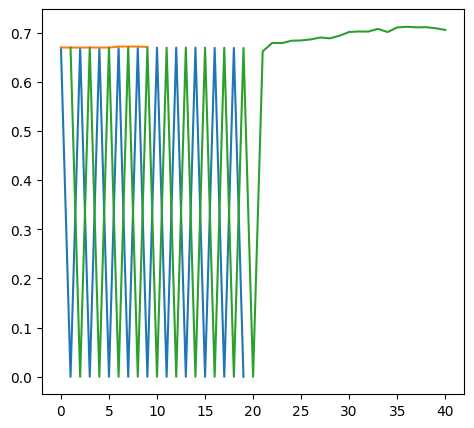

In [12]:
# Combine the histories
def plot_training_history(history, fine_tune_history=None):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    if fine_tune_history is not None:
        # Get the last accuracy values from the first training
        last_acc = history.history['accuracy'][-1]
        last_val_acc = history.history['val_accuracy'][-1]
        
        # Compute the epochs for fine-tuning
        epochs_initial = len(history.history['accuracy'])
        epochs_fine_tune = len(fine_tune_history.history['accuracy'])
        epochs = range(1, epochs_initial + epochs_fine_tune + 1)
        
        # Combine accuracies
        acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
        val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
        
        # Plot the combined accuracies
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        
        # Add a vertical line to indicate when fine-tuning started
        plt.axvline(x=epochs_initial, color='r', linestyle='--', label='Start Fine-tuning')
    
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    if fine_tune_history is not None:
        # Get the last loss values from the first training
        last_loss = history.history['loss'][-1]
        last_val_loss = history.history['val_loss'][-1]
        
        # Combine losses
        loss = history.history['loss'] + fine_tune_history.history['loss']
        val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
        
        # Plot the combined losses
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        
        # Add a vertical line to indicate when fine-tuning started
        plt.axvline(x=epochs_initial, color='r', linestyle='--', label='Start Fine-tuning')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history, fine_tune_history)


47/47 ━━━━━━━━━━━━━━━━━━━━ 29s 620ms/step - accuracy: 0.7094 - loss: 0.8135
Test Loss: 0.8043
Test Accuracy: 0.7073
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 372ms/step

Classification Report:
              precision    recall  f1-score   support

       AKIEC       1.00      0.02      0.04        49
         BCC       0.48      0.34      0.40        77
         BKL       0.34      0.45      0.39       165
          DF       0.00      0.00      0.00        17
         MEL       0.42      0.25      0.32       167
          NV       0.81      0.91      0.86      1006
        VASC       0.00      0.00      0.00        22

    accuracy                           0.71      1503
   macro avg       0.44      0.28      0.29      1503
weighted avg       0.69      0.71      0.68      1503



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


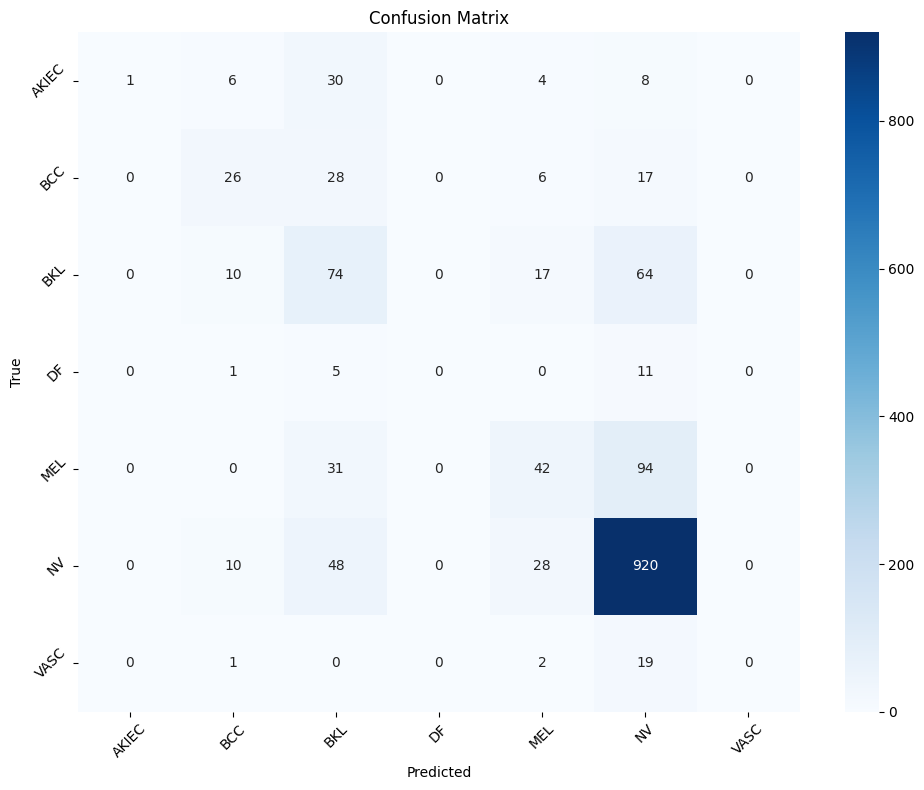

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
class_labels = list(class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


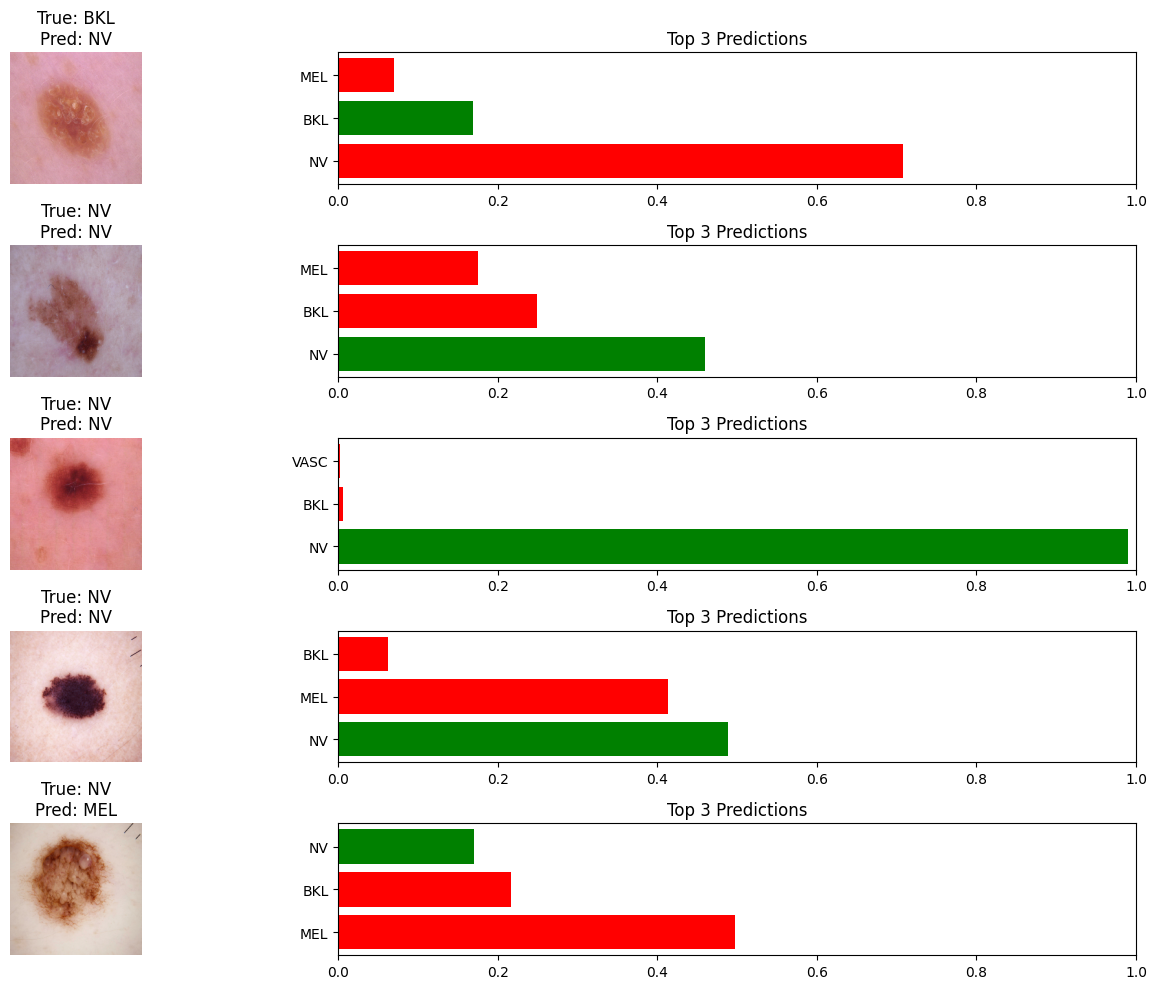

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, generator, class_indices, num_images=10):
    # Get a batch of images
    generator.reset()
    batch_images, batch_labels = next(generator)
    
    # Get predictions
    predictions = model.predict(batch_images)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(batch_labels, axis=1)
    
    # Reverse the class indices for display
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    # Create a figure
    plt.figure(figsize=(15, num_images * 2))
    
    # Display images with predictions
    for i in range(min(num_images, len(batch_images))):
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(batch_images[i])
        plt.title(f"True: {idx_to_class[true_classes[i]]}\nPred: {idx_to_class[pred_classes[i]]}")
        plt.axis('off')
        
        # Display prediction probabilities
        plt.subplot(num_images, 2, 2*i+2)
        probs = predictions[i]
        top_k_idx = np.argsort(probs)[-3:][::-1]  # Top 3 predictions
        top_k_values = probs[top_k_idx]
        top_k_classes = [idx_to_class[idx] for idx in top_k_idx]
        
        colors = ['green' if cls == idx_to_class[true_classes[i]] else 'red' for cls in top_k_classes]
        
        plt.barh(top_k_classes, top_k_values, color=colors)
        plt.xlim(0, 1)
        plt.title('Top 3 Predictions')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_generator, class_indices, num_images=5)


In [16]:
# Save the model
model.save('skin_cancer_resnet152_final.keras')

# Save the class indices
import json
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

print("Model and class indices saved successfully!")


Model and class indices saved successfully!


In [17]:
# Make prediction
predictions = model.predict(img_array)
pred_class_idx = np.argmax(predictions)

# Reverse the class indices for display
idx_to_class = {v: k for k, v in class_indices.items()}
pred_class = idx_to_class[pred_class_idx]

# Get the confidence
confidence = predictions[pred_class_idx]

# Get the full class name
full_class_name = class_names[pred_class]

# Display the image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Prediction: {full_class_name}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

# Return the prediction and confidence
return pred_class, confidence


NameError: name 'img_array' is not defined

In [ ]:
# Make predictions
predictions = model.predict(batch_images)

# Process results
results = []
for i in range(min(num_images, len(batch_images))):
    # Get prediction
    pred_class_idx = np.argmax(predictions[i])
    true_class_idx = np.argmax(batch_labels[i])
    
    # Get class names
    idx_to_class = {v: k for k, v in class_indices.items()}
    pred_class = idx_to_class[pred_class_idx]
    true_class = idx_to_class[true_class_idx]
    
    # Get confidence
    confidence = predictions[i][pred_class_idx]
    
    # Store results
    results.append({
        'image_index': i,
        'predicted_class': pred_class,
        'true_class': true_class,
        'confidence': confidence,
        'correct': pred_class == true_class
    })
    
    # Display image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(batch_images[i])
    plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}\nConf: {confidence:.2f}")
    plt.axis('off')
    plt.show()

# Create a DataFrame with results
results_df = pd.DataFrame(results)
print(f"Accuracy on sample: {results_df['correct'].mean():.2f}")
return results_df


In [ ]:
# Get true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class names for display
idx_to_class = {v: k for k, v in class_indices.items()}
class_names_list = [class_names[idx_to_class[i]] for i in range(len(class_indices))]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names_list, 
            yticklabels=class_names_list)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
report = classification_report(y_true, y_pred_classes, 
                              target_names=class_names_list, 
                              output_dict=True)

# Convert report to DataFrame for better display
report_df = pd.DataFrame(report).transpose()

print(f"Overall Test Accuracy: {accuracy:.4f}")
return report_df


In [ ]:
    def predict_image(image):
        # Convert to numpy array if needed
        if isinstance(image, str):
            # If image is a file path
            img = tf.keras.preprocessing.image.load_img(image, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
        else:
            # If image is already loaded
            img_array = np.array(image)
            img_array = tf.image.resize(img_array, (IMG_SIZE, IMG_SIZE))
            
        # Preprocess
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        
        # Predict
        predictions = model.predict(img_array)
        pred_class_idx = np.argmax(predictions)
        
        # Get class name and confidence
        idx_to_class = {v: k for k, v in class_indices.items()}
        pred_class = idx_to_class[pred_class_idx]
        full_class_name = class_names[pred_class]
        confidence = predictions[pred_class_idx]
        
        # Format result
        result = f"Prediction: {full_class_name}\nConfidence: {confidence:.4f}"
        return result
    
    # Create Gradio interface
    iface = gr.Interface(
        fn=predict_image,
        inputs=gr.Image(type="pil"),
        outputs="text",
        title="Skin Cancer Detection",
        description="Upload a dermoscopic image to detect skin cancer type."
    )
    
    # Launch the app
    iface.launch(share=True)
    
except ImportError:
    print("Gradio is not installed. Please install it with 'pip install gradio'")
    print("You can still use the predict_skin_lesion function directly.")
